In [56]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from PIL import Image


In [43]:
bengin = "Bengin cases"
malignant = "Malignant cases"
normal = "Normal cases"

In [44]:
img_classes = ["Bengin cases", "Malignant cases", "Normal cases"]
path_list = [bengin, malignant, normal]

img_path = []
class_labels = []
for i, dir_list in enumerate(path_list):
    name_img = os.listdir(dir_list)
    for name_file in name_img:
        img = os.path.join(dir_list,name_file)
        img_path.append(img)
        class_labels.append(img_classes[i])

df = pd.DataFrame({"img_path" : img_path,
                  "label" : class_labels})

df.head()

,img_path,label
0,Bengin cases\Bengin case (1).jpg,Bengin cases
1,Bengin cases\Bengin case (10).jpg,Bengin cases
2,Bengin cases\Bengin case (100).jpg,Bengin cases
3,Bengin cases\Bengin case (101).jpg,Bengin cases
4,Bengin cases\Bengin case (102).jpg,Bengin cases


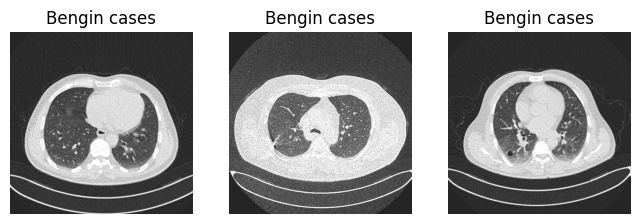

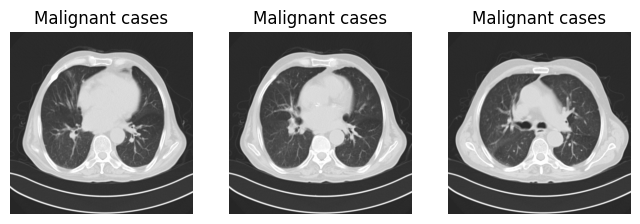

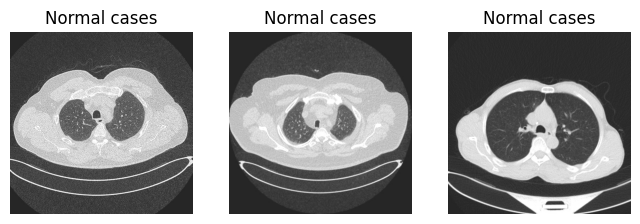

In [49]:
for category, group in df.groupby("label"):
    fig, ax = plt.subplots(1,3, figsize = (8,8))
    ax = ax.ravel()
    for i, (_,r) in enumerate(group.sample(3).iterrows()):
        img = cv2.imread(r.img_path)
        ax[i].imshow(img)
        
        ax[i].axis("off")
        ax[i].set_title(r.label)
    plt.show()

In [47]:
train_ratio = 0.70
test_ratio = 0.15
val_ratio = 0.15

df_train, df_test_val = train_test_split(df, train_size = train_ratio, random_state = 42)
df_test, df_val = train_test_split(df_test_val, train_size = test_ratio/(test_ratio+val_ratio), random_state = 42)

print(f"Train shape = {df_train.shape}")
print(f"Test shape = {df_test.shape}")
print(f"Validation shape = {df_val.shape}")

Train shape = (767, 2)
Test shape = (165, 2)
Validation shape = (165, 2)


(512, 512, 3)

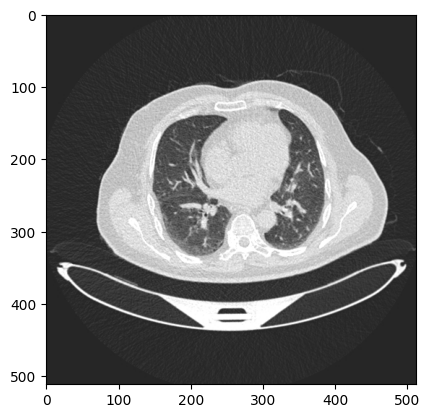

In [60]:
img_path[0]
image = Image.open(img_path[0])
image_array = np.asarray(image)
plt.imshow(image_array)
image_array.shape

In [65]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocessing_denoise(img):
    denoise_img = cv2.medianBlur(img, 1)
    denoise_img = cv2.cvtColor(denoise_img, cv2.COLOR_BGR2RGB)
    return denoise_img

IMG_WIDTH = 227
IMG_HEIGHT = 227

image_size = (IMG_WIDTH, IMG_HEIGHT)
batch_size = 32

TRAIN_DATAGEN = ImageDataGenerator(rescale = 1./255.,
                                   preprocessing_function = preprocessing_denoise,
                                  rotation_range = 30,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.2,
                                  shear_range = 0.1,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

TEST_DATAGEN = ImageDataGenerator(rescale = 1./255.)

train_generator = TRAIN_DATAGEN.flow_from_dataframe(
    df_train,
    x_col = "img_path",
    y_col = "label",
    target_size = image_size,
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode = "categorical",
    shuffle = True
)

val_generator = TEST_DATAGEN.flow_from_dataframe(
    df_val,
    x_col = "img_path",
    y_col = "label",
    target_size = image_size,
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode = "categorical",
    shuffle = True
)

test_generator = TEST_DATAGEN.flow_from_dataframe(
    df_test,
    x_col = "img_path",
    y_col = "label",
    target_size = image_size,
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode = "categorical",
    shuffle = True
)

Found 767 validated image filenames belonging to 3 classes.
Found 165 validated image filenames belonging to 3 classes.
Found 165 validated image filenames belonging to 3 classes.


In [66]:
from sklearn.utils import class_weight
classes = list(train_generator.class_indices.keys())

class_weights = class_weight.compute_class_weight(
           class_weight = 'balanced',
            classes = np.unique(train_generator.classes), 
            y = train_generator.classes)

train_class_weights = dict(enumerate(class_weights))

for idx, weight, in train_class_weights.items():
    class_name = classes[idx]
    print(f"{class_name} : {weight}")

Bengin cases : 3.1958333333333333
Malignant cases : 0.6606373815676141
Normal cases : 0.8522222222222222


In [67]:
model = Sequential()
model.add(Conv2D(filters=96, kernel_size=(11,11),strides=4,input_shape=(227, 227, 3), activation='relu',))
model.add(MaxPool2D(pool_size=(3,3),strides=2))
model.add(Conv2D(filters=256,kernel_size=(5,5),strides=1))
model.add(MaxPool2D(pool_size=(3,3),strides=2))
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=1))
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=1))
model.add(Conv2D(filters=256,kernel_size=(3,3),strides=1))
model.add(MaxPool2D(pool_size=(3,3),strides=2))
model.add(Flatten())
model.add(Dense(4096,activation="relu",))
model.add(Dropout(0.5)) # Thêm lớp Dropout với tỷ lệ dropout là 0.5 (50%) để giảm overfitting
model.add(Dense(4096,activation="relu"))
model.add(Dropout(0.5)) # Thêm lớp Dropout với tỷ lệ dropout là 0.5 (50%) để giảm overfitting
model.add(Dense(3,activation="softmax"))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# In summary của mô hình
model.summary()




c:\Users\ADmin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 23, 23, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 9, 9, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 7, 7, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 5, 5, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4096)           │     4,198,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │        12,291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,739,203 (94.37 MB)

 Trainable params: 24,739,203 (94.37 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
epochs = 50
history = model.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 32,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   epochs = epochs)

Epoch 1/50


c:\Users\ADmin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.2615 - loss: 5.7572 - val_accuracy: 0.1091 - val_loss: 1.5276
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/50


c:\Users\ADmin\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


24/24 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.3204 - loss: 1.4023 - val_accuracy: 0.3636 - val_loss: 1.1647
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 940ms/step - accuracy: 0.3393 - loss: 1.0602 - val_accuracy: 0.1091 - val_loss: 1.1340
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 938ms/step - accuracy: 0.3022 - loss: 1.0796 - val_accuracy: 0.1091 - val_loss: 1.1037
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 27s 981ms/step - accuracy: 0.3262 - loss: 1.0556 - val_accuracy: 0.1091 - val_loss: 1.1061
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - accuracy: 0.0

In [76]:
model.metrics_names

['loss', 'compile_metrics']

In [77]:
def evaluate_model(model, test_generator):
    #Calculate test loss and accuracy
    results = model.evaluate(test_generator, verbose = 0)
    print(f"Test Loss = {results[0]}")
    print(f"Test Accuracy = {results[1]}")

In [78]:
evaluate_model(model, test_generator)


c:\Users\ADmin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Test Loss = 1.1038010120391846
Test Accuracy = 0.3393939435482025
